In [23]:
import pandas as pd
from os.path import join
path_raw = 'D:/Projet'
file_train = 'all_data.csv'
#file_songs = 'songs.csv'
train = pd.read_csv(join(path_raw, file_train), error_bad_lines=False,index_col=0)

C:\Users\moosb\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
n_users = train.memb_id.nunique()
n_songs = train.song_id2.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Songs: '+str(n_songs))

Num. of Users: 30755
Num of Songs: 359914


# On choisit un échantillon de 2000 utilisateurs et 5000 chansons

In [25]:
members=train.memb_id.sample(2000)

In [26]:
songs=train.song_id2.sample(5000)

In [27]:
train=train.loc[train['memb_id'].isin(members.values) & train['song_id2'].isin(songs.values)]

In [28]:
n_users = train.memb_id.nunique()
n_songs = train.song_id2.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Songs: '+str(n_songs))

Num. of Users: 1832
Num of Songs: 3463


In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

cols = ['memb_id', 'song_id2']

for col in cols:
    le.fit(train[col])
    train[col] = le.transform(train[col])

In [30]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train, shuffle=True, test_size=0.2, stratify=train['target'])

# On crée les matrices d'apprentissage et validation en mettant -1 si la target est 0 et 1 si la target est 1 avec des 0 pour les valeurs manquantes

In [31]:
import numpy as np
from scipy.sparse import *
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros( (n_users,n_songs) )
for line in train_data.itertuples():
    train_data_matrix[line[2], line[1]] = 2*line[6]-1

test_data_matrix = np.zeros((n_users, n_songs))
for line in test_data.itertuples():
    test_data_matrix[line[2], line[1]] = 2*line[6]-1

# On calcule les normes euclidiennes des vecteurs lignes de la matrice d'apprentissage pour ensuite normaliser les vecteurs lignes des matrices d'apprentissage et de validation

In [32]:
magnitude = np.sqrt(np.square(train_data_matrix).sum(axis=1))
train_data_matrix = np.where(np.isclose(magnitude,0)[:,None], 0, train_data_matrix/magnitude[:,None])
test_data_matrix = np.where(np.isclose(magnitude,0)[:,None], 0, test_data_matrix/magnitude[:,None])

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt


#  fonction qui permet de calculer l'erreur
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

# SVD avec RMSE

In [44]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import numpy as np
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 50)
u=u[:,::-1]
s=s[::-1]
vt=vt[::-1,:]
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('SVD-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

SVD-based CF MSE: 0.07326892806384945


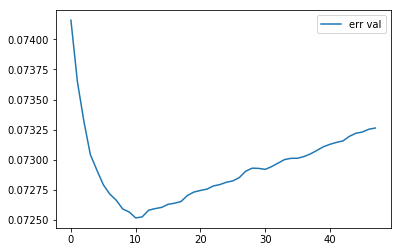

In [45]:
error_app=list()
error_val=list()
for i in range(2,50):
    s_diag_matrix=np.diag(s[:i])
    X_pred = np.dot(np.dot(u[:,0:i], s_diag_matrix), vt[0:i])
    error_app.append(rmse(X_pred, train_data_matrix))
    error_val.append(rmse(X_pred, test_data_matrix))
from matplotlib import pyplot as plt

#plt.plot(error_app,label='err app')  
plt.plot(error_val,label='err val')
plt.legend()
plt.show()

In [46]:
ind_min=np.argmin(error_val)

In [47]:
ind_min

10

In [48]:
u, s, vt = svds(train_data_matrix, k = ind_min)
u=u[:,::-1]
s=s[::-1]
vt=vt[::-1,:]
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('SVD-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

SVD-based CF MSE: 0.07259198552900077


# Calcul du score de classification

In [49]:
svd_prediction=pd.DataFrame(np.dot(np.dot(u, s_diag_matrix), vt),index=range(n_users),columns=range(n_songs))

In [50]:
def evaluate(x):
    if x>0:
        return 1
    else:
        return 0

l=[]
for line in test_data.values:
    l.append(evaluate(svd_prediction.loc[line[1],line[0]]))

In [51]:
target=test_data.target.values

In [52]:
1-np.sum(np.abs(target-l))/target.size

0.67781366203888371

# Moindres carrés alternés

In [53]:
W = train_data_matrix!=0
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

Wt = test_data_matrix!=0
Wt[Wt == True] = 1
Wt[Wt == False] = 0
# To be consistent with our Q matrix
Wt = Wt.astype(np.float64, copy=False)

In [54]:
from scipy.sparse.linalg import svds

n_factors = ind_min
lambda_ = 0.1
m, n = train_data_matrix.shape
n_iterations = 20

#u=np.random.rand(m, n_factors)
#vt=np.random.rand(n_factors, n)


u, s, vt = svds(train_data_matrix, k = n_factors)
u=u[:,::-1]# taille (943,3)
s=s[::-1] # vect col taille 3
vt=vt[::-1,:] # taille (3,1682)
vt = np.dot(np.diag(s),vt)

def get_error(Q, X, Y, W):
    return sqrt(np.sum(( W*(Q - np.dot(X, Y)))**2)/np.sum(W))

get_error(test_data_matrix, u, vt, Wt)

0.07259198552900076

In [55]:
weighted_errors = []
weighted_errors_app= []
for ii in range(n_iterations):
    for j, Wj in enumerate(W.T):# fixe u et optimise v (parcours des films)
        XtWX =np.dot(u.T, np.dot(np.diag(Wj), u))
        vt[:,j] = np.linalg.solve(XtWX + lambda_ * np.eye(n_factors),
                               np.dot(u.T, np.dot(np.diag(Wj), train_data_matrix[:,j])))
    for i, Wi in enumerate(W):# fixe v et optimise u (parcours des utilisateurs)
        YWYt =np.dot(vt, np.dot(np.diag(Wi), vt.T))
        u[i] = np.linalg.solve(YWYt + lambda_ * np.eye(n_factors),
                                 np.dot(vt, np.dot(np.diag(Wi), train_data_matrix[i].T))).T
  
    weighted_errors.append(get_error(test_data_matrix, u, vt, Wt))
    weighted_errors_app.append(get_error(train_data_matrix, u, vt, W))
    print('{}th iteration is completed, error val: {}, error app: {}'.format(ii,weighted_errors[ii],weighted_errors_app[ii]))

0th iteration is completed, error val: 0.0725002923749821, error app: 0.06016995446919294
1th iteration is completed, error val: 0.07370501891868615, error app: 0.056172288543228956
2th iteration is completed, error val: 0.07412584629468323, error app: 0.055362525768183256


KeyboardInterrupt: 

# Calcul du score de classification

In [56]:
als_prediction=pd.DataFrame(Wt*np.dot(u,vt),index=range(n_users),columns=range(n_songs))

In [57]:
def evaluate(x):
    if x>0:
        return 1
    else:
        return 0

l=[]
for line in test_data.values:
    l.append(evaluate(als_prediction.loc[line[1],line[0]]))

In [58]:
target=test_data.target.values

In [59]:
1-np.sum(np.abs(target-l))/target.size

0.67683578018245216

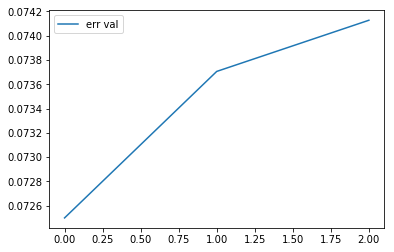

In [60]:
plt.plot(weighted_errors,label='err val')
plt.legend()
plt.show()

# Descente de gradient stochastique

In [61]:
n_factors = ind_min  # number of factors
alpha = .1  # learning rate
n_epochs = 20  # numb

#u=np.random.rand(m, n_factors)
#vt=np.random.rand(n_factors, n)

u, s, vt = svds(train_data_matrix, k = n_factors)
u=u[:,::-1]# taille (943,3)
s=s[::-1] # vect col taille 3
vt=vt[::-1,:] # taille (3,1682)
vt = np.dot(np.diag(s),vt)

get_error(test_data_matrix, u, vt, Wt)

0.07259198552900076

In [62]:
weighted_errors = []
weighted_errors_app= []
    # Optimization procedure
for k in range(n_epochs):
    for i in range(m):
        for j in range(n):
            if train_data_matrix[i][j]!=0:
                err = train_data_matrix[i][j] - np.dot(u[i], vt[:,j])
        # Update vectors p_u and q_i
                u[i] += alpha * err * vt[:,j]
                vt[:,j] += alpha * err * u[i]
    weighted_errors.append(get_error(test_data_matrix, u, vt, Wt))
    weighted_errors_app.append(get_error(train_data_matrix, u, vt, W))
    print('{}th iteration is completed, error val: {}, error app: {}'.format(k,weighted_errors[k],weighted_errors_app[k]))

0th iteration is completed, error val: 0.07100166156644731, error app: 0.06775641341859326
1th iteration is completed, error val: 0.07065261134121949, error app: 0.06662887166722475
2th iteration is completed, error val: 0.07047552806980564, error app: 0.06580334633094083
3th iteration is completed, error val: 0.07036227737594233, error app: 0.06511774842208899
4th iteration is completed, error val: 0.07028501548906495, error app: 0.06451621643091768
5th iteration is completed, error val: 0.07023572826042411, error app: 0.06397445811245432
6th iteration is completed, error val: 0.07021133262876147, error app: 0.06347958880002336


KeyboardInterrupt: 

In [63]:
stoch_prediction=pd.DataFrame(Wt*np.dot(u,vt),index=range(n_users),columns=range(n_songs))

In [64]:
def evaluate(x):
    if x>0:
        return 1
    else:
        return 0

l=[]
for line in test_data.values:
    l.append(evaluate(stoch_prediction.loc[line[1],line[0]]))

In [65]:
target=test_data.target.values

In [66]:
1-np.sum(np.abs(target-l))/target.size

0.68618999215121135

# Filtrage collaboratif

In [33]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [34]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [35]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [36]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 0.0756556104455714
Item-based CF RMSE: 0.07680563670279625


In [37]:
user_based_prediction=pd.DataFrame(user_prediction,index=range(n_users),columns=range(n_songs))
item_based_prediction=pd.DataFrame(item_prediction,index=range(n_users),columns=range(n_songs))

In [38]:
def evaluate(x):
    if x>0:
        return 1
    else:
        return 0

l=[]
for line in test_data.values:
    l.append(evaluate(user_based_prediction.loc[line[1],line[0]]))

In [39]:
target=test_data.target.values

In [40]:
1-np.sum(np.abs(target-l))/target.size

0.65067744052290943

In [41]:
def evaluate(x):
    if x>0:
        return 1
    else:
        return 0

l=[]
for line in test_data.values:
    l.append(evaluate(item_based_prediction.loc[line[1],line[0]]))

In [42]:
target=test_data.target.values

In [43]:
1-np.sum(np.abs(target-l))/target.size

0.64447561085448868